# Investors' Sentiment & S&P500 : EDA
---

# Notebook Organisation:
1. Data Collection - Subreddit
2. Data Collection - Target 
3. Merging Data
2. **EDA and Preprocessing (Current Notebook)**
3. Model Tuning and Insights

# Import Library
---

In [120]:
import requests
import time
import nltk
import pandas as pd
import regex as re
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import warnings
import string
from datetime import datetime
import datetime as dt
from tqdm import tqdm

import nltk
nltk.downloader.download('vader_lexicon')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer, TweetTokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from wordcloud import WordCloud, ImageColorGenerator
from matplotlib_venn import venn2

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
warnings.filterwarnings('ignore')
sns.set_style('ticks')
%matplotlib inline

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\benja\AppData\Roaming\nltk_data...


# Read CSV
---

In [153]:
# Target Variable
target = pd.read_csv("data/sp500_diff.csv")

# Data for Combination of title & post for 2019
titlepost_df = pd.read_csv("data/project_titlepost2019_df_cleaned.csv")

# Data for Combination of title on a daily basis for 2019 & 2020
dailytitle_df = pd.read_csv("data/project_df_dailytitle_cleaned.csv")

## Target Variable

In [136]:
target.head()

Date         Open         High          Low        Close  Adj Close  \
0  2019-01-02  2476.959961  2519.489990  2467.469971  2510.030029    2510.03   
1  2019-01-03  2491.919922  2493.139893  2443.959961  2447.889893    2447.89   
2  2019-01-04  2474.330078  2538.070068  2474.330078  2531.939941    2531.94   
3  2019-01-07  2535.610107  2566.159912  2524.560059  2549.689941    2549.69   
4  2019-01-08  2568.110107  2579.820068  2547.560059  2574.409912    2574.41   

       Volume  month  year       Diff  Percent_Change Percent_Change_Class  
0  3733160000      1  2019        NaN             NaN                  NaN  
1  3822860000      1  2019 -62.140137       -0.025385                 down  
2  4213410000      1  2019  84.050050        0.033196                   up  
3  4104710000      1  2019  17.750000        0.006962                   up  
4  4083030000      1  2019  24.719970        0.009602                   up

In [137]:
target.dropna(inplace=True)
target['Date'] = pd.to_datetime(target['Date']).dt.date
target.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 504 entries, 1 to 504
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  504 non-null    object 
 1   Open                  504 non-null    float64
 2   High                  504 non-null    float64
 3   Low                   504 non-null    float64
 4   Close                 504 non-null    float64
 5   Adj Close             504 non-null    float64
 6   Volume                504 non-null    int64  
 7   month                 504 non-null    int64  
 8   year                  504 non-null    int64  
 9   Diff                  504 non-null    float64
 10  Percent_Change        504 non-null    float64
 11  Percent_Change_Class  504 non-null    object 
dtypes: float64(7), int64(3), object(2)
memory usage: 51.2+ KB


## Title and Post combined

In [243]:
titlepost_df.head(3)

date                                              title  \
0  2019-01-03 18:02:40               Backtesting moving average crossover   
1  2019-01-03 20:12:03  Can someone ELI5 what a cross signal Index is ...   
2  2019-01-03 20:54:22  Your AM Global Stocks Preview and a whole lot ...   

                                            selftext  is_self  upvotes  \
0  Hello guys,  \nI was trying to backtest a movi...      1.0      1.0   
1  I just finished Margin call on Netflix and was...      1.0      1.0   
2   \n\n### US Stocks\n\n* **US stocks index futu...      1.0      1.0   

   n_comments                                          permalink  \
0         0.0  /r/stocks/comments/ac4c0u/backtesting_moving_a...   
1         0.0  /r/stocks/comments/ac55o3/can_someone_eli5_wha...   
2        16.0  /r/stocks/comments/ac5gf6/your_am_global_stock...   

                 author  month  year                 Date year_and_month  \
0     bhandarimohit2029      1  2019  2019-01-03 00:00:00        2019-01   
1        tellmetheworld      1  2019  2019-01-03 00:00:00        2019-01   
2  QuantalyticsResearch      1  2019  2019-01-03 00:00:00        2019-01   

   week_of_year percent_change_class  title_len  text_len  \
0             1                   up          4       212   
1             1                   up         16        59   
2             1                   up         24      1033   

                                 first_title_cleaned  \
0               backtesting moving average crossover   
1        someone eli cross signal index used trading   
2  global stock preview whole lot news need read ...   

                              first_selftext_cleaned  \
0  hello guy trying backtest moving average cross...   
1  finished margin call netflix intrigued using i...   
2  u stock u stock index future dropping sharply ...   

                          final_title_cleaned  \
0                backtesting moving crossover   
1                      someone eli cross used   
2  preview whole negative guidance aapl spook   

                              final_selftext_cleaned  \
0  hello backtest moving crossover indian found i...   
1  call netflix intrigued indicator sort proof sk...   
2  u u dropping sharply front p negative guidance...   

                                          fresh_meat  \
0  backtesting moving average crossover hello guy...   
1  someone eli cross signal index used trading fi...   
2  global stock preview whole lot news need read ...   

                                           lean_meat  lean_meat_len  
0  backtesting moving crossover hello backtest mo...             85  
1  someone eli cross used call netflix intrigued ...             24  
2  preview whole negative guidance aapl spook u u...            327

In [244]:
titlepost_df.tail(3)

date                                              title  \
67479  2019-12-31 00:30:53  $GD breakdown on weakness. Put it on the watch...   
67480  2019-12-31 05:55:28       What to study other than Technical Analysis?   
67481  2019-12-31 14:15:07                  Eye Catching Technologies in 2020   

                                                selftext  is_self  upvotes  \
67479                                             notext      0.0      1.0   
67480  So I have been practicing using technical anal...      1.0      1.0   
67481                                             notext      0.0      1.0   

       n_comments                                          permalink  \
67479         0.0  /r/technicalanalysis/comments/eho7g8/gd_breakd...   
67480         8.0  /r/technicalanalysis/comments/ehstqt/what_to_s...   
67481         1.0  /r/technicalanalysis/comments/ehyz6f/eye_catch...   

                    author  month  year                 Date year_and_month  \
67479  StocksAndStones-com     12  2019  2019-12-31 00:00:00        2019-12   
67480             omaradas     12  2019  2019-12-31 00:00:00        2019-12   
67481           CyberCisin     12  2019  2019-12-31 00:00:00        2019-12   

       week_of_year percent_change_class  title_len  text_len  \
67479             1                   up         10         1   
67480             1                   up          7        31   
67481             1                   up          5         1   

                        first_title_cleaned  \
67479  gd breakdown weakness put watch list   
67480              study technical analysis   
67481               eye catching technology   

                                  first_selftext_cleaned  \
67479                                             notext   
67480  practicing using technical analysis long anyth...   
67481                                             notext   

                        final_title_cleaned  \
67479  gd breakdown weakness put watch list   
67480                        study analysis   
67481                          eye catching   

                                  final_selftext_cleaned  \
67479                                                NaN   
67480  practicing analysis anything learn addition an...   
67481                                                NaN   

                                              fresh_meat  \
67479        gd breakdown weakness put watch list notext   
67480  study technical analysis practicing using tech...   
67481                     eye catching technology notext   

                                               lean_meat  lean_meat_len  
67479              gd breakdown weakness put watch list               7  
67480  study analysis practicing analysis anything le...             10  
67481                                      eye catching               3

In [245]:
titlepost_df['date'] = pd.to_datetime(titlepost_df['date'])
titlepost_df['Date'] = titlepost_df['date'].dt.date
titlepost_df['month'] = titlepost_df['date'].dt.month
titlepost_df['year'] = titlepost_df['date'].dt.year
titlepost_df.loc[:, 'year_and_month'] = titlepost_df.loc[:, 'date'].apply(lambda x: '{}-{:02d}'.format(x.year, x.month))
titlepost_df.loc[:, 'week_of_year'] = titlepost_df.loc[:, 'date'].dt.isocalendar().week

In [246]:
titlepost_df.dropna(inplace=True)
titlepost_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35516 entries, 0 to 67480
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   date                    35516 non-null  datetime64[ns]
 1   title                   35516 non-null  object        
 2   selftext                35516 non-null  object        
 3   is_self                 35516 non-null  float64       
 4   upvotes                 35516 non-null  float64       
 5   n_comments              35516 non-null  float64       
 6   permalink               35516 non-null  object        
 7   author                  35516 non-null  object        
 8   month                   35516 non-null  int64         
 9   year                    35516 non-null  int64         
 10  Date                    35516 non-null  object        
 11  year_and_month          35516 non-null  object        
 12  week_of_year            35516 non-null  UInt32

## Title Combined on a Daily Basis

In [142]:
dailytitle_df.head(3)

Date                                     combined_title  \
0  2019-01-03  Backtesting moving average crossover Can someo...   
1  2019-01-04  What’s your best performing stock today? How t...   
2  2019-01-07  Come Join Quantum Stock Trading! Help reach fi...   

  percent_change_class  title_len  \
0                   up        108   
1                   up        503   
2                   up        209   

                                       title_cleaned  
0  backtesting moving average crossover someone e...  
1  best performing stock today explain option new...  
2  come join quantum stock trading help reach fin...

In [143]:
dailytitle_df.tail(3)

Date                                     combined_title  \
499  2020-12-28  Stock Community Apps Investing in lOGI ? Stock...   
500  2020-12-29  Need Investment Help GHIV - Largest SPAC Deal ...   
501  2020-12-30  Year-end summary. It has been a wild ride! If ...   

    percent_change_class  title_len  \
499                 down       9685   
500                   up      13645   
501                   up      13164   

                                         title_cleaned  
499  stock community apps investing logi stock port...  
500  need investment help ghiv largest spac deal ev...  
501  year end summary wild ride inherited k would b...

In [224]:
dailytitle_df['Date'] = pd.to_datetime(dailytitle_df['Date'])
dailytitle_df['month'] = dailytitle_df['Date'].dt.month
dailytitle_df['year'] = dailytitle_df['Date'].dt.year
dailytitle_df.loc[:, 'year_and_month'] = dailytitle_df.loc[:, 'Date'].apply(lambda x: '{}-{:02d}'.format(x.year, x.month))
dailytitle_df.loc[:, 'week_of_year'] = dailytitle_df.loc[:, 'Date'].dt.isocalendar().week
dailytitle_df['Date'] = dailytitle_df['Date'].dt.date

In [225]:
dailytitle_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 502 entries, 0 to 501
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  502 non-null    object 
 1   combined_title        502 non-null    object 
 2   percent_change_class  502 non-null    object 
 3   title_len             502 non-null    int64  
 4   title_cleaned         502 non-null    object 
 5   sentiment_pos         502 non-null    float64
 6   sentiment_neu         502 non-null    float64
 7   sentiment_neg         502 non-null    float64
 8   sentiment_compound    502 non-null    float64
 9   month                 502 non-null    int64  
 10  year                  502 non-null    int64  
 11  year_and_month        502 non-null    object 
 12  week_of_year          502 non-null    UInt32 
dtypes: UInt32(1), float64(4), int64(3), object(5)
memory usage: 49.6+ KB


# Exploratory Data Analysis
---

## Sentiment Analysis using NLTK

In Sentiment Analysis, both dailytitle and titlepost dataset shows that even the most positive or negative sentiment, contains posts that were either in the up or down trend in either sentiments. This is also possibily due to having neutrality within some of the posts. 

In [156]:
# Instantiating sentiment intensity analyzer
sia = SIA()

### Sentiment Analysis on Title Combined on Daily Basis

In [247]:
dailytitle_df['title_cleaned'][0]

'backtesting moving average crossover someone eli cross signal index used trading global preview whole lot news need read negative guidance apple aapl spook global gld outperforms snp dow alternative yahoo finance roth ira contribution thread aapl crash revealing billion loss q result long take etf reflect underlying asset best european online broker trading option apple term market cap k rollover ira question negative divdends microsoft today'

In [227]:
sia.polarity_scores(dailytitle_df['title_cleaned'][0])

{'neg': 0.161, 'neu': 0.752, 'pos': 0.087, 'compound': -0.6908}

In [228]:
def get_sentiment_dailytitle(row):
    sentiment_dict = sia.polarity_scores(row['title_cleaned'])
    row['sentiment_pos'] = sentiment_dict['pos']
    row['sentiment_neu'] = sentiment_dict['neu']
    row['sentiment_neg'] = sentiment_dict['neg']
    row['sentiment_compound'] = sentiment_dict['compound']
    return row

In [229]:
dailytitle_df = dailytitle_df.apply(get_sentiment_dailytitle, axis=1)

In [230]:
dailytitle_df.head()

Date                                     combined_title  \
0  2019-01-03  Backtesting moving average crossover Can someo...   
1  2019-01-04  What’s your best performing stock today? How t...   
2  2019-01-07  Come Join Quantum Stock Trading! Help reach fi...   
3  2019-01-08  Greenspan says stock market "is still a bit to...   
4  2019-01-09  ONC, ONCY &amp; ONC.WT What is everyone's opin...   

  percent_change_class  title_len  \
0                   up        108   
1                   up        503   
2                   up        209   
3                   up        541   
4                   up        472   

                                       title_cleaned  sentiment_pos  \
0  backtesting moving average crossover someone e...          0.087   
1  best performing stock today explain option new...          0.130   
2  come join quantum stock trading help reach fin...          0.179   
3  greenspan say stock market still bit high appl...          0.219   
4  onc oncy amp onc wt everyone opinion company d...          0.126   

   sentiment_neu  sentiment_neg  sentiment_compound  month  year  \
0          0.752          0.161             -0.6908      1  2019   
1          0.771          0.099              0.8470      1  2019   
2          0.709          0.112              0.8481      1  2019   
3          0.737          0.044              0.9947      1  2019   
4          0.761          0.113              0.5423      1  2019   

  year_and_month  week_of_year  
0        2019-01             1  
1        2019-01             1  
2        2019-01             2  
3        2019-01             2  
4        2019-01             2

#### Most Positive

In [166]:
# Most positive headlines
dailytitle_df.loc[dailytitle_df['sentiment_pos'].sort_values(ascending=False).index][['title_cleaned', 'percent_change_class', 'sentiment_pos', 'sentiment_neg',
                                                                     'sentiment_neu', 'sentiment_compound']].head(5)

title_cleaned percent_change_class  \
24  first researched pick pcty well first well res...                   up   
33  newb question tell stock overbought thought go...                   up   
45  long term let play game thought hain china gdp...                   up   
36  general electric stock first robbin hood margi...                 down   
65  ar augmented reality daily profit get weed fol...                 down   

    sentiment_pos  sentiment_neg  sentiment_neu  sentiment_compound  
24          0.270          0.028          0.702              0.9955  
33          0.250          0.060          0.690              0.9924  
45          0.238          0.045          0.717              0.9849  
36          0.237          0.080          0.683              0.9928  
65          0.234          0.035          0.731              0.9867

#### Most Negative

In [168]:
# Most negative headlines
dailytitle_df.loc[dailytitle_df['sentiment_neg'].sort_values(ascending=False).index][['title_cleaned', 'percent_change_class', 'sentiment_pos', 'sentiment_neg',
                                                                     'sentiment_neu', 'sentiment_compound']].head(5)

title_cleaned percent_change_class  \
255  hidden fee charles schwab thinking getting tod...                   up   
292  robinhood much robinhood make lose morning tes...                   up   
315  exactly msft microsof affected purchase profit...                   up   
367  sma line moving average line someone explain h...                 down   
309  short long term tax question newer investor ta...                 down   

     sentiment_pos  sentiment_neg  sentiment_neu  sentiment_compound  
255          0.152          0.179          0.669             -0.9992  
292          0.158          0.176          0.666             -0.9999  
315          0.142          0.173          0.684             -0.9999  
367          0.145          0.167          0.689             -0.9998  
309          0.163          0.163          0.674             -0.9986

### Sentiment Analysis on Combined Title+Post

In [248]:
titlepost_df['fresh_meat'][0]

'backtesting moving average crossover hello guy trying backtest moving average crossover strategy indian stock market data found interesting observation condition used long moving average day cross moving average day algosim syntax meansma close gt meansma close short moving average day cross moving average day algosim syntax meansma close lt meansma close entered stop loss target tried stagey different stock like sbin infy stock screenshot included infy long side usually profit historically short side give good result market bull larger period time imply avoid shorting strategy overall get better result condition use improve strategy anyone could give example data provided ohlc volume tried adding condition volume greater moving average volume day volume gt meansma volume improvement result satisfactory anyone suggestion advice give please comment would love health conversation screenshots backtest amp x b'

In [249]:
titlepost_df['lean_meat'][0]

'backtesting moving crossover hello backtest moving crossover indian found interesting observation condition used moving cross moving algosim syntax meansma meansma moving cross moving algosim syntax meansma lt meansma entered stop target tried stagey different sbin infy screenshot included infy side usually historically side give bull larger period imply avoid shorting overall get condition improve anyone could give example provided ohlc volume tried adding condition volume greater moving volume volume meansma volume improvement satisfactory anyone suggestion give please comment would love conversation screenshots backtest x b'

In [250]:
# Instantiating sentiment intensity analyzer
print(sia.polarity_scores(titlepost_df['fresh_meat'][0]))
print()
print(sia.polarity_scores(titlepost_df['lean_meat'][0]))

{'neg': 0.043, 'neu': 0.73, 'pos': 0.227, 'compound': 0.9794}

{'neg': 0.045, 'neu': 0.751, 'pos': 0.204, 'compound': 0.9403}


In [251]:
def get_sentiment_freshmeat(row):
    sentiment_dict = sia.polarity_scores(row['fresh_meat'])
    row['sentiment_pos'] = sentiment_dict['pos']
    row['sentiment_neu'] = sentiment_dict['neu']
    row['sentiment_neg'] = sentiment_dict['neg']
    row['sentiment_compound'] = sentiment_dict['compound']
    return row

In [252]:
def get_sentiment_leanmeat(row):
    sentiment_dict = sia.polarity_scores(row['lean_meat'])
    row['sentiment_pos'] = sentiment_dict['pos']
    row['sentiment_neu'] = sentiment_dict['neu']
    row['sentiment_neg'] = sentiment_dict['neg']
    row['sentiment_compound'] = sentiment_dict['compound']
    return row

In [253]:
titlepost_df = titlepost_df.apply(get_sentiment_freshmeat, axis=1)
titlepost_df = titlepost_df.apply(get_sentiment_leanmeat, axis=1)

####  Most Positive

In [254]:
# Most positive headlines
titlepost_df.loc[titlepost_df['sentiment_pos'].sort_values(ascending=False).index][['fresh_meat', 'percent_change_class', 'sentiment_pos', 'sentiment_neg',
                                                                     'sentiment_neu', 'sentiment_compound']].head(5)

fresh_meat percent_change_class  \
21495                                  nice job nice job                 down   
25788       amazon play guy think amazon earnings coming                   up   
62505        yay like investing yay yay favorite etf yay                 down   
15980  brave new world billion dollar loss praised st...                 down   
5832   question playing clean energy long term clean ...                 down   

       sentiment_pos  sentiment_neg  sentiment_neu  sentiment_compound  
21495            1.0            0.0            0.0              0.6808  
25788            1.0            0.0            0.0              0.3400  
62505            1.0            0.0            0.0              0.9485  
15980            1.0            0.0            0.0              0.8720  
5832             1.0            0.0            0.0              0.8957

In [255]:
# Most positive headlines
titlepost_df.loc[titlepost_df['sentiment_pos'].sort_values(ascending=False).index][['lean_meat', 'percent_change_class', 'sentiment_pos', 'sentiment_neg',
                                                                     'sentiment_neu', 'sentiment_compound']].head(5)

lean_meat percent_change_class  \
21495                                   nice nice                 down   
25788                               amazon amazon                   up   
62505                    yay yay yay favorite yay                 down   
15980                    brave praised strong x b                 down   
5832   playing clean energy clean energy security                 down   

       sentiment_pos  sentiment_neg  sentiment_neu  sentiment_compound  
21495            1.0            0.0            0.0              0.6808  
25788            1.0            0.0            0.0              0.3400  
62505            1.0            0.0            0.0              0.9485  
15980            1.0            0.0            0.0              0.8720  
5832             1.0            0.0            0.0              0.8957

####  Most Negative

In [256]:
# Most negative headlines
titlepost_df.loc[titlepost_df['sentiment_neg'].sort_values(ascending=False).index][['fresh_meat', 'percent_change_class', 'sentiment_pos', 'sentiment_neg',
                                                                     'sentiment_neu', 'sentiment_compound']].head(5)

fresh_meat percent_change_class  \
16800                        analyst biased amp x b                   up   
56028  best lazy portfolio lazy portfolio index etf                   up   
22490                         fucking idiot amp x b                   up   
25016                               guy stupid hell                   up   
18088               stop making tesla post annoying                   up   

       sentiment_pos  sentiment_neg  sentiment_neu  sentiment_compound  
16800            0.0            1.0            0.0             -0.2732  
56028            0.0            1.0            0.0             -0.6124  
22490            0.0            1.0            0.0             -0.5106  
25016            0.0            1.0            0.0             -0.8402  
18088            0.0            1.0            0.0             -0.5994

In [257]:
# Most negative headlines
titlepost_df.loc[titlepost_df['sentiment_neg'].sort_values(ascending=False).index][['lean_meat', 'percent_change_class', 'sentiment_pos', 'sentiment_neg',
                                                                     'sentiment_neu', 'sentiment_compound']].head(5)

lean_meat percent_change_class  sentiment_pos  sentiment_neg  \
16800     biased x b                   up            0.0            1.0   
56028      lazy lazy                   up            0.0            1.0   
22490      idiot x b                   up            0.0            1.0   
25016    stupid hell                   up            0.0            1.0   
18088  stop annoying                   up            0.0            1.0   

       sentiment_neu  sentiment_compound  
16800            0.0             -0.2732  
56028            0.0             -0.6124  
22490            0.0             -0.5106  
25016            0.0             -0.8402  
18088            0.0             -0.5994

## Number of Post by Year/Month/Day
---

### Number of Post by Year

Number of posts by year shows a high surge from one year to another. 
This was due to the pandemic faced in 2020 which caused a lot of uncertainty within the stock market and worries among the investors.

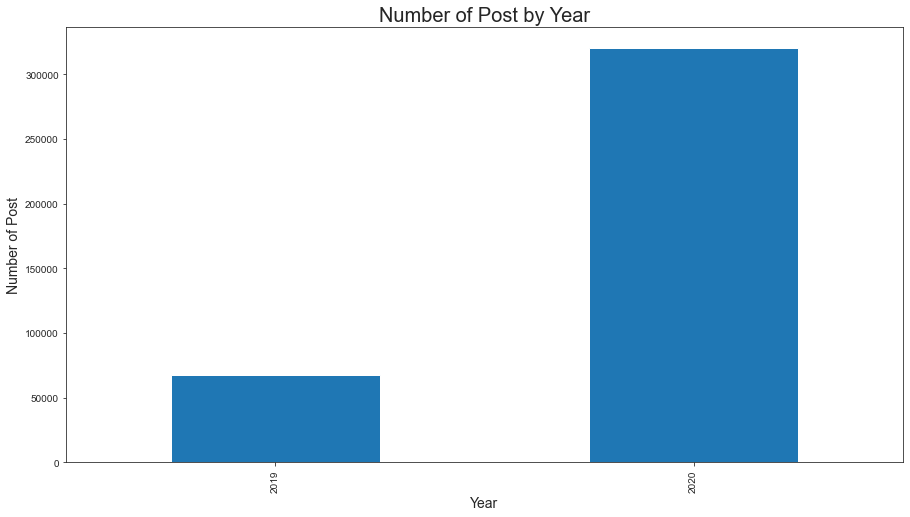

In [27]:
# Number of post by year
dailytitle_df['title'].groupby([dailytitle_df.date.dt.year]).agg('count').plot(kind='bar', figsize=(15,8))
plt.title("Number of Post by Year", fontsize=20)
plt.ylabel('Number of Post', fontsize=14)
plt.xlabel('Year', fontsize=14);

#### Reason for surge in Post

Comparing year-on-year, keywords like Covid, Corona, Correction, Market Crash, appeared more in 2020 as compared with 2019.

In [232]:
dailytitle_df_2019 = dailytitle_df[dailytitle_df['year'] == 2019]
dailytitle_df_2020 = dailytitle_df[dailytitle_df['year'] == 2020]

In [236]:
print(dailytitle_df_2019['title_cleaned'].str.contains('covid', regex=False).value_counts())
print()
print(dailytitle_df_2020['title_cleaned'].str.contains('covid', regex=False).value_counts())

False    251
Name: title_cleaned, dtype: int64

True     219
False     32
Name: title_cleaned, dtype: int64


In [238]:
print(dailytitle_df_2019['title_cleaned'].str.contains('corona', regex=False).value_counts())
print()
print(dailytitle_df_2020['title_cleaned'].str.contains('corona', regex=False).value_counts())

False    249
True       2
Name: title_cleaned, dtype: int64

True     211
False     40
Name: title_cleaned, dtype: int64


In [239]:
print(dailytitle_df_2019['title_cleaned'].str.contains('correction', regex=False).value_counts())
print()
print(dailytitle_df_2020['title_cleaned'].str.contains('correction', regex=False).value_counts())

False    204
True      47
Name: title_cleaned, dtype: int64

False    130
True     121
Name: title_cleaned, dtype: int64


In [240]:
print(dailytitle_df_2019['title_cleaned'].str.contains('market crash', regex=False).value_counts())
print()
print(dailytitle_df_2020['title_cleaned'].str.contains('market crash', regex=False).value_counts())

False    194
True      57
Name: title_cleaned, dtype: int64

True     200
False     51
Name: title_cleaned, dtype: int64


### Number of Post by year_month

Generally, in 2019, the number of posts was less than 10,000 per month as there was nothing significant occuring during that year. However, in 2020, the number of posts surged throughout the months. Especially in Mar 2020, where there was a huge market correction which got many investors concerned. Hence, the huge spike in the number of posts.

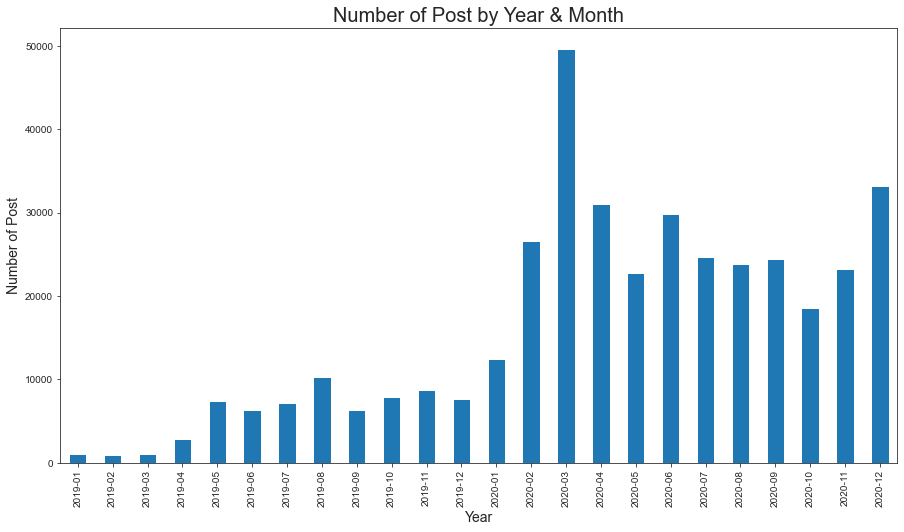

In [28]:
# Number of post by year_month
dailytitle_df['title'].groupby([dailytitle_df.year_and_month]).agg('count').plot(kind='bar', figsize=(15,8))
plt.title("Number of Post by Year & Month", fontsize=20)
plt.ylabel('Number of Post', fontsize=14)
plt.xlabel('Year', fontsize=14);

### Number of Post by Month

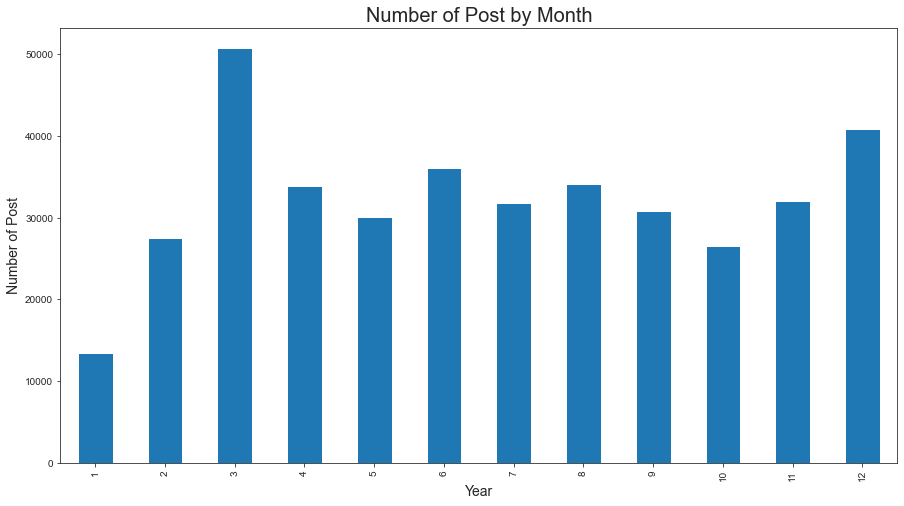

In [29]:
# Number of post by Month
dailytitle_df['title'].groupby([dailytitle_df.month]).agg('count').plot(kind='bar', figsize=(15,8))
plt.title("Number of Post by Month", fontsize=20)
plt.ylabel('Number of Post', fontsize=14)
plt.xlabel('Year', fontsize=14);

### Number of Post by Week of Year

In [30]:
# Number of posts per day
dailytitle_df['title'].groupby([dailytitle_df.week_of_year]).agg('count').plot(kind='bar', figsize=(15,8))
plt.title("Number of Post by Week of Year", fontsize=20)
plt.ylabel('Number of Post', fontsize=12)
plt.xlabel('Week of Year', fontsize=12);

## Target Variable - Spikes changes within 2019-2020

### S&P500 Trend throughout 2019 - 2020

Comparing the number of posts, it seems to indicate that in an event of a significant change in the market, the number of posts for that month will significantly increase also.

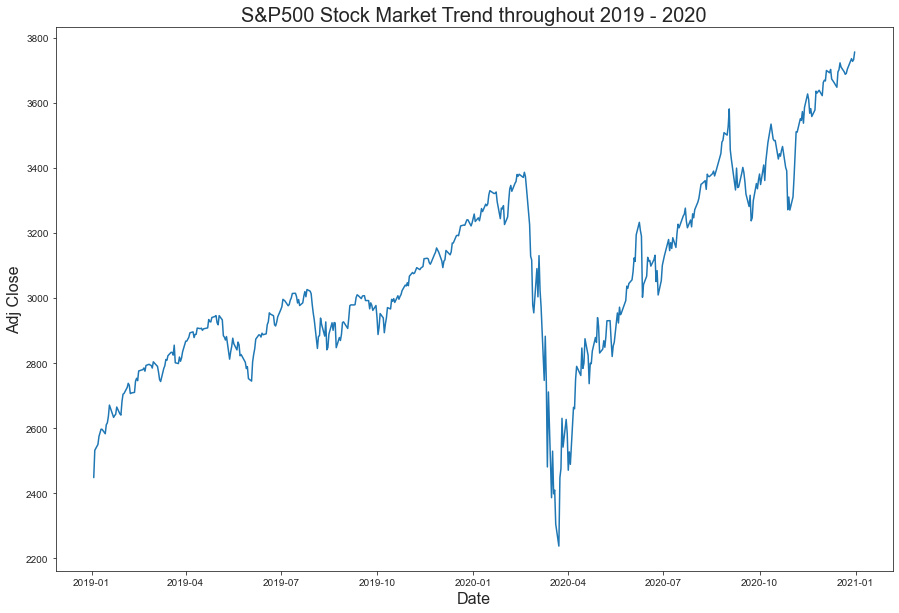

In [91]:
plt.figure(figsize=(15,10))
ax = sns.lineplot(data=target, x="Date", y="Adj Close")
ax.set_title('S&P500 Stock Market Trend throughout 2019 - 2020',fontsize=20)
ax.set_ylabel('Adj Close', fontsize=16)
ax.set_xlabel('Date', fontsize=16);

### Significant Changes throughout 2019 - 2020

In [93]:
plt.figure(figsize=(15,10))
ax = sns.lineplot(data=target, x="Date", y="Percent_Change")
ax.set_title('Significant Changes throughout 2019 - 2020',fontsize=20)
ax.set_ylabel('Percentage of Change', fontsize=16)
ax.set_xlabel('Date', fontsize=16);

### Dates of Significant Changes Throughout 2019 - 2020

Most dates show that there was a huge change in the period of March 2020. Hence, top 30 changes during the period of 2019 and 2020 are mainly due to performance of the stock market in March 2020.


In [97]:
plt.figure(figsize=(10,10))
ax = sns.barplot(data = target.sort_values(by='abs_change', ascending=False).head(30), x='abs_change', y='Date')
ax.set_title('Significant Changes throughout 2019 - 2020',fontsize=20)
ax.set_ylabel('Date', fontsize=16)
ax.set_xlabel('Percentage of Change', fontsize=16);

## EDA Based on Combined Title & Post in 2019
---

The EDA was done to see the effect of cleaning(using stopwords) to reduce the similarity between both up and down trends.

### Top 50 Title-Post Content for Ups/Downs

In [260]:
titlepost_df.shape

(35516, 27)

In [261]:
ups = titlepost_df[(titlepost_df['percent_change_class'] == 'up')]
downs = titlepost_df[(titlepost_df['percent_change_class'] == 'down')]

In [262]:
print(ups['percent_change_class'].unique())
print(ups['percent_change_class'].shape)
print(downs['percent_change_class'].unique())
print(downs['percent_change_class'].shape)

['up']
(21253,)
['down']
(14263,)


### Before and After Cleaning of Common Words in Ups & Downs

In the following EDA, the top 50 uni-gram/bi-gram/trigram were reflected with emphasis to two stages; (1) Before increasing the stopwords and (2) After increasing the stopwords.

#### Top 50 Word Before Cleaning

Before cleaning, there are a huge amount of similar words between the Up and down trends. Zooming into the venn diagram in the later portion(in 5.4.6.1), there are **49 common words prior to cleaning**.

In [277]:
# instantiate a basic vectoriser with only settings for extracting bi- and tri-grams
cvec = CountVectorizer(stop_words = 'english', ngram_range = (1,1), max_features=1000)

# upz - fit/transform count vectoriser to title and get the 50 phrases with the highest count
before_uni_upz = cvec.fit_transform(ups['fresh_meat'])
before_uni_upz = pd.DataFrame(before_uni_upz.toarray(), columns = cvec.get_feature_names())
before_uni_upz_title_50 = before_uni_upz.sum().sort_values(ascending=False).head(50)

# downz - fit/transform count vectoriser to title and get the 50 phrases with the highest count
before_uni_downz = cvec.fit_transform(downs['fresh_meat'])
before_uni_downz = pd.DataFrame(before_uni_downz.toarray(), columns = cvec.get_feature_names())
before_uni_downz_title_50 = before_uni_downz.sum().sort_values(ascending=False).head(50)

# plot results
fit, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(15,10), sharex = True)

sns.barplot(y=before_uni_upz_title_50.index.values, x = before_uni_upz_title_50,color='skyblue',ax=ax[0])
ax[0].set_title('top 50 words in UPs',fontsize=16)
ax[0].set_xlabel('count of words/phrases', fontsize=13)
plt.setp(ax[0].get_yticklabels(), fontsize=14)

sns.barplot(y=before_uni_downz_title_50.index.values, x = before_uni_downz_title_50,color='skyblue',ax=ax[1])
ax[1].set_title('top 50 words in DOWN',fontsize=16)
ax[1].set_xlabel('count of words/phrases', fontsize=13)
plt.setp(ax[1].get_yticklabels(), fontsize=14)

plt.tight_layout()

#### Top 50 Word After Cleaning

Despite cleaning, there still remains a huge amount of similar words between the Up and down trends. Zooming into the venn diagram in the later portion(in 5.4.6.2), there are **still 40 common words**.

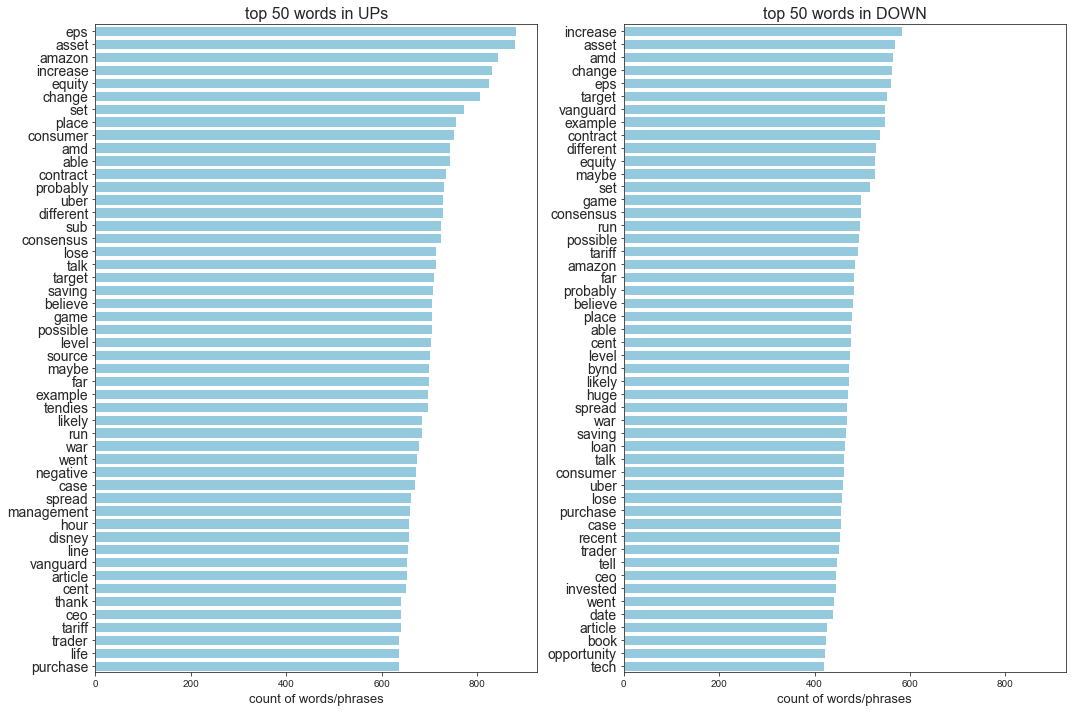

In [282]:
# instantiate a basic vectoriser with only settings for extracting bi- and tri-grams
cvec = CountVectorizer(stop_words = 'english', ngram_range = (1,1), max_features=1000)

# upz - fit/transform count vectoriser to title and get the 50 phrases with the highest count
after_uni_upz = cvec.fit_transform(ups['lean_meat'])
after_uni_upz = pd.DataFrame(after_uni_upz.toarray(), columns = cvec.get_feature_names())
after_uni_upz_title_50 = after_uni_upz.sum().sort_values(ascending=False).head(50)

# downz - fit/transform count vectoriser to title and get the 50 phrases with the highest count
after_uni_downz = cvec.fit_transform(downs['lean_meat'])
after_uni_downz = pd.DataFrame(after_uni_downz.toarray(), columns = cvec.get_feature_names())
after_uni_downz_title_50 = after_uni_downz.sum().sort_values(ascending=False).head(50)

# plot results
fit, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(15,10), sharex = True)

sns.barplot(y=after_uni_upz_title_50.index.values, x = after_uni_upz_title_50,color='skyblue',ax=ax[0])
ax[0].set_title('top 50 words in UPs',fontsize=16)
ax[0].set_xlabel('count of words/phrases', fontsize=13)
plt.setp(ax[0].get_yticklabels(), fontsize=14)

sns.barplot(y=after_uni_downz_title_50.index.values, x = after_uni_downz_title_50,color='skyblue',ax=ax[1])
ax[1].set_title('top 50 words in DOWN',fontsize=16)
ax[1].set_xlabel('count of words/phrases', fontsize=13)
plt.setp(ax[1].get_yticklabels(), fontsize=14)

plt.tight_layout()

#### Top 50 Bigrams Before Cleaning

Before cleaning, there are a huge amount of similar words between the Up and down trends. Zooming into the venn diagram in the later portion(in 5.4.6.3), there are **43 common words prior to cleaning**.

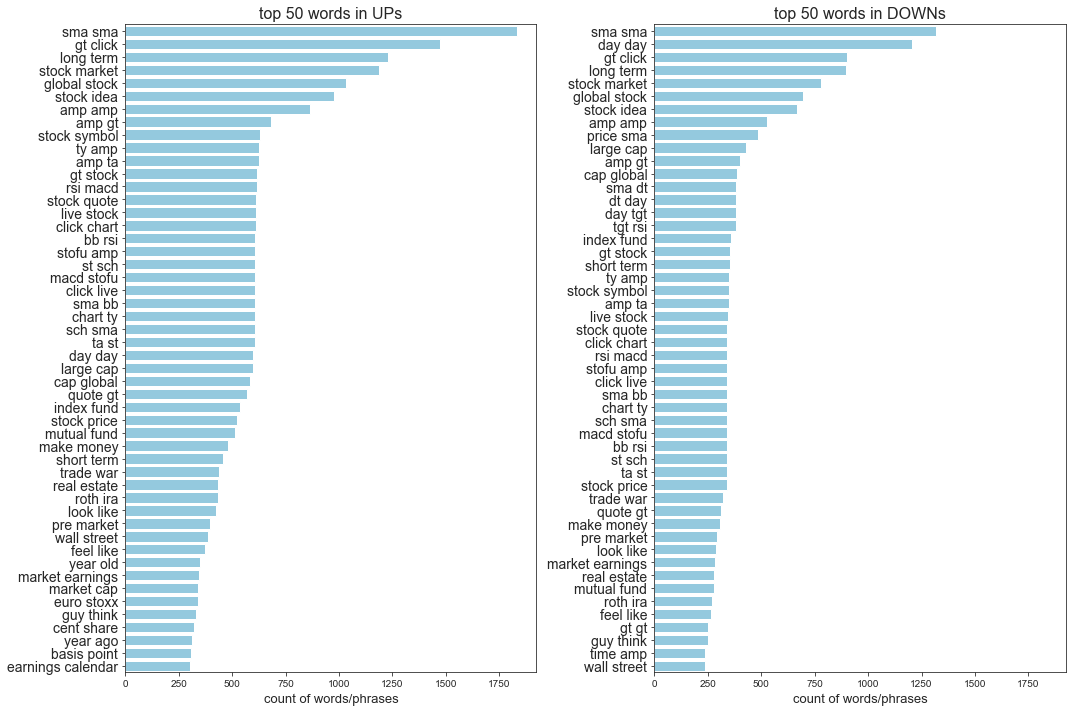

In [305]:
# instantiate a basic vectoriser with only settings for extracting bi- and tri-grams
cvec = CountVectorizer(stop_words = 'english', ngram_range = (2,2), max_features=1000)

# upz - fit/transform count vectoriser to title and get the 50 phrases with the highest count
before_bi_upz = cvec.fit_transform(ups['fresh_meat'])
before_bi_upz = pd.DataFrame(before_bi_upz.toarray(), columns = cvec.get_feature_names())
before_bi_upz_title_50 = before_bi_upz.sum().sort_values(ascending=False).head(50)

# downz - fit/transform count vectoriser to title and get the 50 phrases with the highest count
before_bi_downz = cvec.fit_transform(downs['fresh_meat'])
before_bi_downz = pd.DataFrame(before_bi_downz.toarray(), columns = cvec.get_feature_names())
before_bi_downz_title_50 = before_bi_downz.sum().sort_values(ascending=False).head(50)

# plot results
fit, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(15,10), sharex = True)

sns.barplot(y=before_bi_upz_title_50.index.values, x = before_bi_upz_title_50,color='skyblue',ax=ax[0])
ax[0].set_title('top 50 words in UPs',fontsize=16)
ax[0].set_xlabel('count of words/phrases', fontsize=13)
plt.setp(ax[0].get_yticklabels(), fontsize=14)

sns.barplot(y=before_bi_downz_title_50.index.values, x = before_bi_downz_title_50,color='skyblue',ax=ax[1])
ax[1].set_title('top 50 words in DOWNs',fontsize=16)
ax[1].set_xlabel('count of words/phrases', fontsize=13)
plt.setp(ax[1].get_yticklabels(), fontsize=14)

plt.tight_layout()

#### Top 50 Bigrams After Cleaning

Despite cleaning, there still remains a huge amount of similar words between the Up and down trends. Zooming into the venn diagram in the later portion(in 5.4.6.4), there are **still 29 common words**.

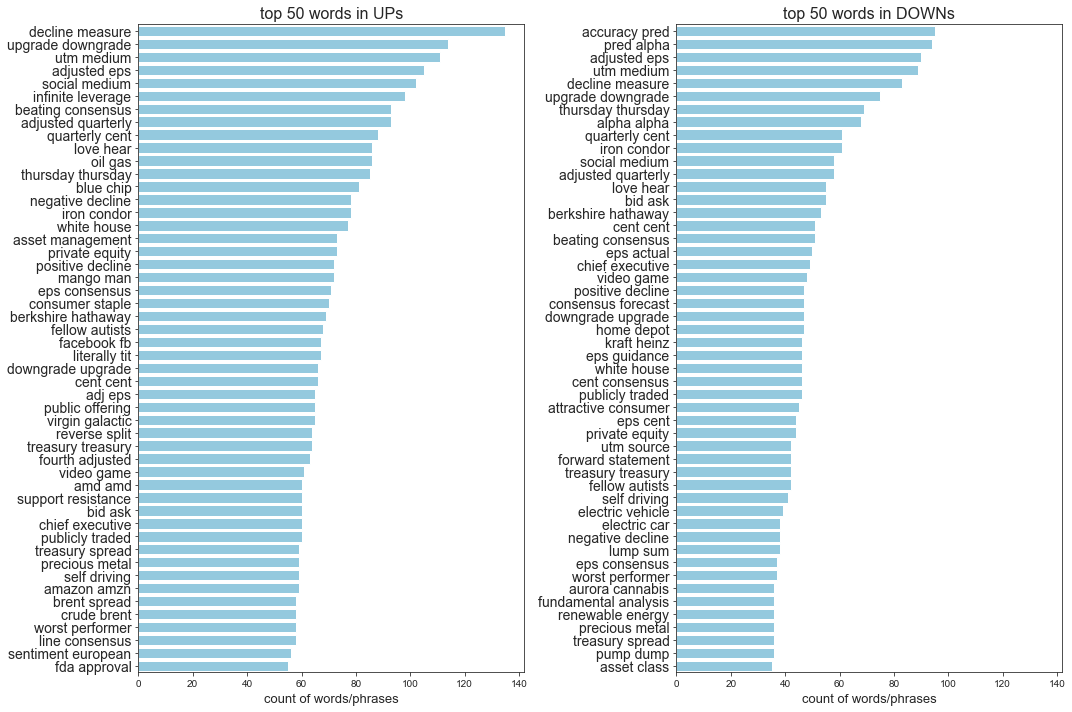

In [284]:
# instantiate a basic vectoriser with only settings for extracting bi- and tri-grams
cvec = CountVectorizer(stop_words = 'english', ngram_range = (2,2), max_features=1000)

# upz - fit/transform count vectoriser to title and get the 50 phrases with the highest count
after_bi_upz = cvec.fit_transform(ups['lean_meat'])
after_bi_upz = pd.DataFrame(after_bi_upz.toarray(), columns = cvec.get_feature_names())
after_bi_upz_title_50 = after_bi_upz.sum().sort_values(ascending=False).head(50)

# downz - fit/transform count vectoriser to title and get the 50 phrases with the highest count
after_bi_downz = cvec.fit_transform(downs['lean_meat'])
after_bi_downz = pd.DataFrame(after_bi_downz.toarray(), columns = cvec.get_feature_names())
after_bi_downz_title_50 = after_bi_downz.sum().sort_values(ascending=False).head(50)

# plot results
fit, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(15,10), sharex = True)

sns.barplot(y=after_bi_upz_title_50.index.values, x = after_bi_upz_title_50,color='skyblue',ax=ax[0])
ax[0].set_title('top 50 words in UPs',fontsize=16)
ax[0].set_xlabel('count of words/phrases', fontsize=13)
plt.setp(ax[0].get_yticklabels(), fontsize=14)

sns.barplot(y=after_bi_downz_title_50.index.values, x = after_bi_downz_title_50,color='skyblue',ax=ax[1])
ax[1].set_title('top 50 words in DOWNs',fontsize=16)
ax[1].set_xlabel('count of words/phrases', fontsize=13)
plt.setp(ax[1].get_yticklabels(), fontsize=14)

plt.tight_layout()

#### Top 50 Trigrams Before Cleaning

Before cleaning, there are a huge amount of similar words between the Up and down trends. Zooming into the venn diagram in the later portion(in 5.4.6.5), there are **38 common words prior to cleaning**.

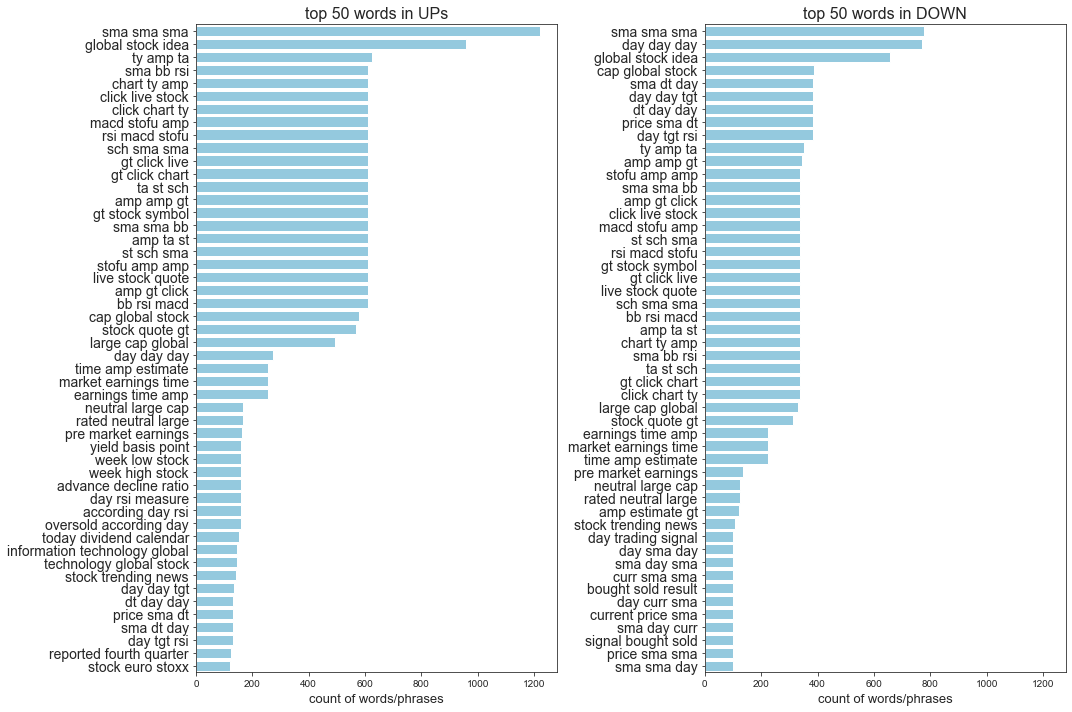

In [304]:
# instantiate a basic vectoriser with only settings for extracting bi- and tri-grams
cvec = CountVectorizer(stop_words = 'english', ngram_range = (3,3), max_features=1000)

# upz - fit/transform count vectoriser to title and get the 50 phrases with the highest count
before_tri_upz = cvec.fit_transform(ups['fresh_meat'])
before_tri_upz = pd.DataFrame(before_tri_upz.toarray(), columns = cvec.get_feature_names())
before_tri_upz_title_50 = before_tri_upz.sum().sort_values(ascending=False).head(50)

# downz - fit/transform count vectoriser to title and get the 50 phrases with the highest count
before_tri_downz = cvec.fit_transform(downs['fresh_meat'])
before_tri_downz = pd.DataFrame(before_tri_downz.toarray(), columns = cvec.get_feature_names())
before_tri_downz_title_50 = before_tri_downz.sum().sort_values(ascending=False).head(50)

# plot results
fit, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(15,10), sharex = True)

sns.barplot(y=before_tri_upz_title_50.index.values, x = before_tri_upz_title_50,color='skyblue',ax=ax[0])
ax[0].set_title('top 50 words in UPs',fontsize=16)
ax[0].set_xlabel('count of words/phrases', fontsize=13)
plt.setp(ax[0].get_yticklabels(), fontsize=14)

sns.barplot(y=before_tri_downz_title_50.index.values, x = before_tri_downz_title_50,color='skyblue',ax=ax[1])
ax[1].set_title('top 50 words in DOWN',fontsize=16)
ax[1].set_xlabel('count of words/phrases', fontsize=13)
plt.setp(ax[1].get_yticklabels(), fontsize=14)

plt.tight_layout()

#### Top 50 Trigrams After Cleaning

Despite cleaning, there still remains a huge amount of similar words between the Up and down trends. Zooming into the venn diagram in the later portion(in 5.4.6.6), there are **still 30 common words**.

In [286]:
# instantiate a basic vectoriser with only settings for extracting bi- and tri-grams
cvec = CountVectorizer(stop_words = 'english', ngram_range = (3,3), max_features=1000)

# upz - fit/transform count vectoriser to title and get the 50 phrases with the highest count
after_tri_upz = cvec.fit_transform(ups['lean_meat'])
after_tri_upz = pd.DataFrame(after_tri_upz.toarray(), columns = cvec.get_feature_names())
after_tri_upz_title_50 = after_tri_upz.sum().sort_values(ascending=False).head(50)

# downz - fit/transform count vectoriser to title and get the 50 phrases with the highest count
after_tri_downz = cvec.fit_transform(downs['lean_meat'])
after_tri_downz = pd.DataFrame(after_tri_downz.toarray(), columns = cvec.get_feature_names())
after_tri_downz_title_50 = after_tri_downz.sum().sort_values(ascending=False).head(50)

# plot results
fit, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(15,10), sharex = True)

sns.barplot(y=after_tri_upz_title_50.index.values, x = after_tri_upz_title_50,color='skyblue',ax=ax[0])
ax[0].set_title('top 50 words in UPs',fontsize=16)
ax[0].set_xlabel('count of words/phrases', fontsize=13)
plt.setp(ax[0].get_yticklabels(), fontsize=14)

sns.barplot(y=after_tri_downz_title_50.index.values, x = after_tri_downz_title_50,color='skyblue',ax=ax[1])
ax[1].set_title('top 50 words in DOWN',fontsize=16)
ax[1].set_xlabel('count of words/phrases', fontsize=13)
plt.setp(ax[1].get_yticklabels(), fontsize=14)

plt.tight_layout()

### Boxplot of Title and Post For Up and Down Trend

In [266]:
# plot distributions with same x axis range for each category
fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (20, 8))

sns.boxplot(ups['title_len'], ax = ax[0][0], width = 0.2)
ax[0][0].set_xlabel('')
ax[0][0].set_xlim(-5,60)
ax[0][0].set_title('UP Title Length', fontsize=14)
sns.boxplot(ups['text_len'], ax = ax[0][1], width = 0.2)
ax[0][1].set_xlabel('')
ax[0][1].set_xlim(-100,1750)
ax[0][1].set_title('UP Post Length', fontsize=14)
sns.boxplot(ups['lean_meat_len'], ax = ax[0][2], width = 0.2)
ax[0][2].set_xlabel('')
ax[0][2].set_xlim(-100,1750)
ax[0][2].set_title('UP Title-Post Length', fontsize=14)

sns.boxplot(downs['title_len'], ax = ax[1][0], width = 0.2)
ax[1][0].set_xlabel('')
ax[1][0].set_xlim(-5,60)
ax[1][0].set_title('DOWN Title lengths', fontsize=14)
sns.boxplot(downs['text_len'], ax = ax[1][1], width = 0.2)
ax[1][1].set_xlabel('')
ax[1][1].set_xlim(-100,1750)
ax[1][1].set_title('DOWN Post Lengths', fontsize=14)
sns.boxplot(downs['lean_meat_len'], ax = ax[1][2], width = 0.2)
ax[1][2].set_xlabel('')
ax[1][2].set_xlim(-100,1750)
ax[1][2].set_title('DOWN Title-Post Length', fontsize=14)

plt.tight_layout();

### Histogram of Title and Post for Up and Down Trend

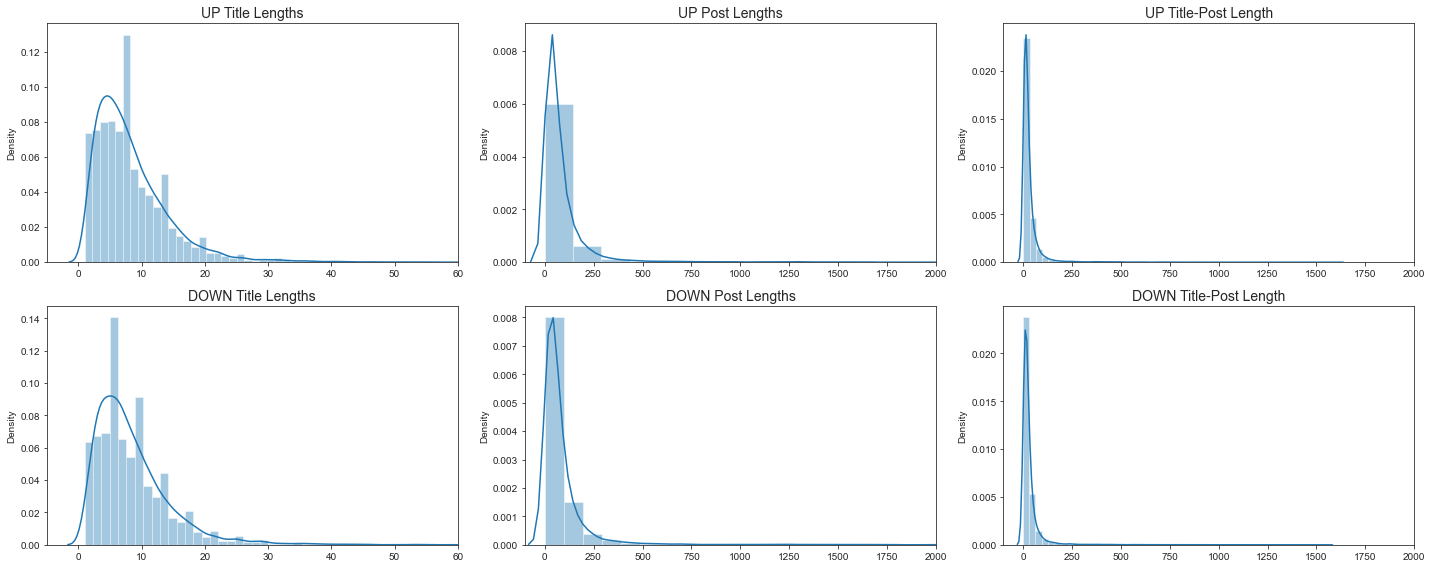

In [268]:
# plot distributions with same x axis range for each category
fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (20, 8))

sns.distplot(ups['title_len'], ax = ax[0][0])
ax[0][0].set_xlabel('')
ax[0][0].set_xlim(-5,60)
ax[0][0].set_title('UP Title Lengths', fontsize=14)
sns.distplot(ups['text_len'], ax = ax[0][1])
ax[0][1].set_xlabel('')
ax[0][1].set_xlim(-100,2000)
ax[0][1].set_title('UP Post Lengths', fontsize=14)
sns.distplot(ups['lean_meat_len'], ax = ax[0][2])
ax[0][2].set_xlabel('')
ax[0][2].set_xlim(-100,2000)
ax[0][2].set_title('UP Title-Post Length', fontsize=14)

sns.distplot(downs['title_len'], ax = ax[1][0])
ax[1][0].set_xlabel('')
ax[1][0].set_xlim(-5,60)
ax[1][0].set_title('DOWN Title Lengths', fontsize=14)
sns.distplot(downs['text_len'], ax = ax[1][1])
ax[1][1].set_xlabel('')
ax[1][1].set_xlim(-100,2000)
ax[1][1].set_title('DOWN Post Lengths', fontsize=14)
sns.distplot(downs['lean_meat_len'], ax = ax[1][2])
ax[1][2].set_xlabel('')
ax[1][2].set_xlim(-100,2000)
ax[1][2].set_title('DOWN Title-Post Length', fontsize=14)

plt.tight_layout()

### WordCloud for UP and Down Trend

#### Uni-gram Before Cleaning

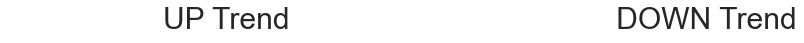

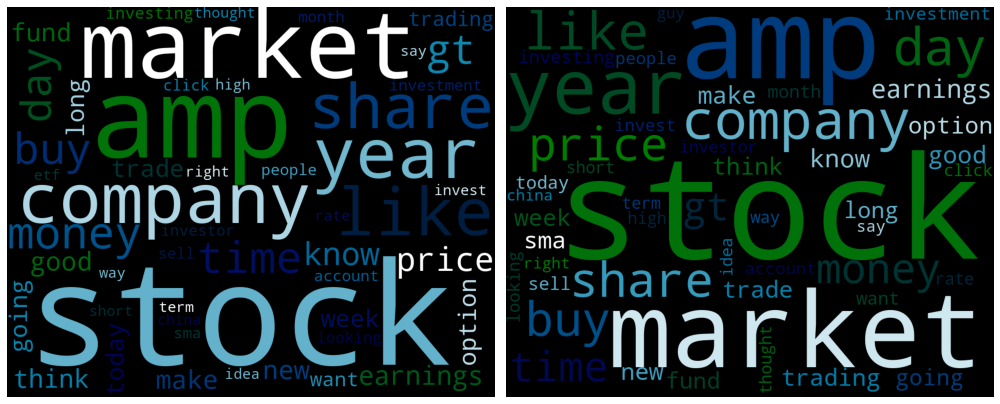

In [306]:
# set up WordCloud
wc_up = WordCloud(max_words= 50, width = 1000, height = 800, background_color ='black',
                  colormap='ocean').generate_from_frequencies(before_uni_upz_title_50) 

wc_down = WordCloud(max_words= 50, width = 1000, height = 800, background_color ='black',
                  colormap='ocean').generate_from_frequencies(before_uni_downz_title_50) 

plt.figure(figsize=(8, 0.3))
plt.text(x = 0.35,                              
         y = 0.9,                             
         s = 'UP Trend                                       DOWN Trend', 
         ha = 'left',                        
         va = 'center',                       
         size = 30)                         
plt.axis('off')

# plot the WordCloud image 
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (14, 6))
ax[0].imshow(wc_up)
ax[0].axis('off')
ax[1].imshow(wc_down)
ax[1].axis('off')
plt.tight_layout()

#### Uni-gram After Cleaning

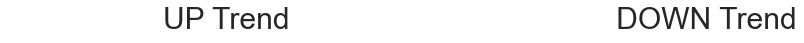

In [307]:
# set up WordCloud
wc_up = WordCloud(max_words= 50, width = 1000, height = 800, background_color ='black',
                  colormap='ocean').generate_from_frequencies(after_uni_upz_title_50) 

wc_down = WordCloud(max_words= 50, width = 1000, height = 800, background_color ='black',
                  colormap='ocean').generate_from_frequencies(after_uni_downz_title_50) 

plt.figure(figsize=(8, 0.3))
plt.text(x = 0.35,                              
         y = 0.9,                             
         s = 'UP Trend                                       DOWN Trend', 
         ha = 'left',                        
         va = 'center',                       
         size = 30)                         
plt.axis('off')

# plot the WordCloud image 
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (14, 6))
ax[0].imshow(wc_up)
ax[0].axis('off')
ax[1].imshow(wc_down)
ax[1].axis('off')
plt.tight_layout()

#### Bi-gram Before Cleaning

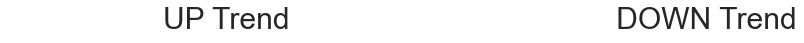

In [308]:
# set up WordCloud
bi_wc_up = WordCloud(max_words= 50, width = 1000, height = 800, background_color ='black',
                  colormap='ocean').generate_from_frequencies(before_bi_upz_title_50) 

bi_wc_down = WordCloud(max_words= 50, width = 1000, height = 800, background_color ='black',
                  colormap='ocean').generate_from_frequencies(before_bi_downz_title_50) 

plt.figure(figsize=(8, 0.3))
plt.text(x = 0.35,                              
         y = 0.9,                             
         s = 'UP Trend                                       DOWN Trend', 
         ha = 'left',                        
         va = 'center',                       
         size = 30)                         
plt.axis('off')

# plot the WordCloud image 
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (14, 6))
ax[0].imshow(bi_wc_up)
ax[0].axis('off')
ax[1].imshow(bi_wc_down)
ax[1].axis('off')
plt.tight_layout()

#### Bi-gram After Cleaning

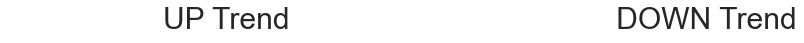

In [309]:
# set up WordCloud
bi_wc_up = WordCloud(max_words= 50, width = 1000, height = 800, background_color ='black',
                  colormap='ocean').generate_from_frequencies(after_bi_upz_title_50) 

bi_wc_down = WordCloud(max_words= 50, width = 1000, height = 800, background_color ='black',
                  colormap='ocean').generate_from_frequencies(after_bi_downz_title_50) 

plt.figure(figsize=(8, 0.3))
plt.text(x = 0.35,                              
         y = 0.9,                             
         s = 'UP Trend                                       DOWN Trend', 
         ha = 'left',                        
         va = 'center',                       
         size = 30)                         
plt.axis('off')

# plot the WordCloud image 
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (14, 6))
ax[0].imshow(bi_wc_up)
ax[0].axis('off')
ax[1].imshow(bi_wc_down)
ax[1].axis('off')
plt.tight_layout()

#### Tri-gram Before Cleaning

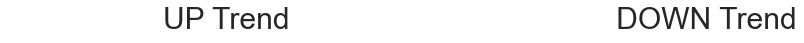

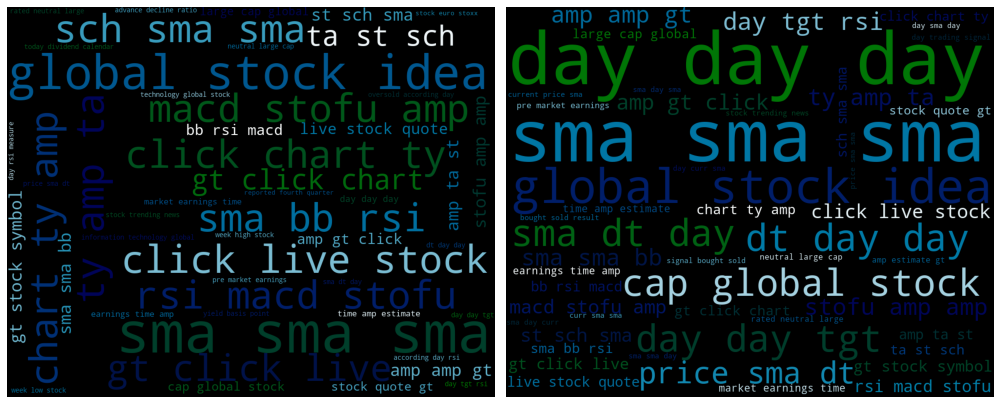

In [310]:
# set up WordCloud
tri_wc_up = WordCloud(max_words= 50, width = 1000, height = 800, background_color ='black',
                  colormap='ocean').generate_from_frequencies(before_tri_upz_title_50) 

tri_wc_down = WordCloud(max_words= 50, width = 1000, height = 800, background_color ='black',
                  colormap='ocean').generate_from_frequencies(before_tri_downz_title_50) 

plt.figure(figsize=(8, 0.3))
plt.text(x = 0.35,                              
         y = 0.9,                             
         s = 'UP Trend                                       DOWN Trend', 
         ha = 'left',                        
         va = 'center',                       
         size = 30)                         
plt.axis('off')

# plot the WordCloud image 
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (14, 6))
ax[0].imshow(tri_wc_up)
ax[0].axis('off')
ax[1].imshow(tri_wc_down)
ax[1].axis('off')
plt.tight_layout()

#### Tri-gram After Cleaning

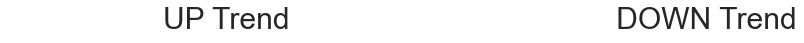

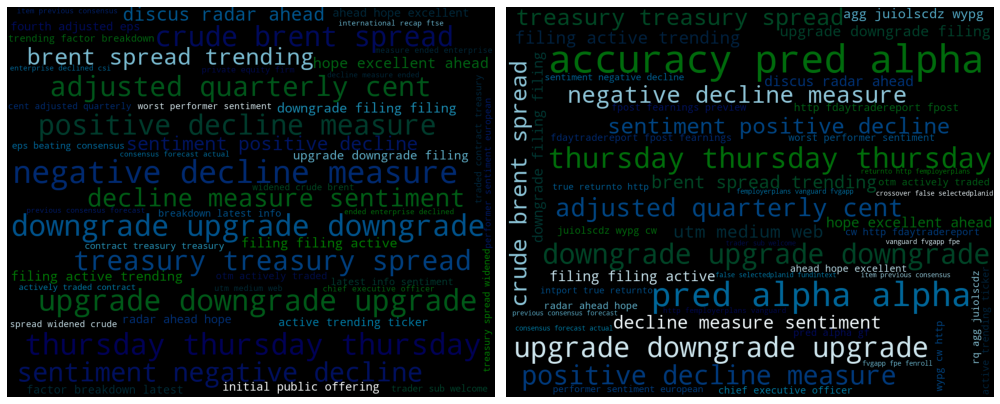

In [311]:
# set up WordCloud
tri_wc_up = WordCloud(max_words= 50, width = 1000, height = 800, background_color ='black',
                  colormap='ocean').generate_from_frequencies(after_tri_upz_title_50) 

tri_wc_down = WordCloud(max_words= 50, width = 1000, height = 800, background_color ='black',
                  colormap='ocean').generate_from_frequencies(after_tri_downz_title_50) 

plt.figure(figsize=(8, 0.3))
plt.text(x = 0.35,                              
         y = 0.9,                             
         s = 'UP Trend                                       DOWN Trend', 
         ha = 'left',                        
         va = 'center',                       
         size = 30)                         
plt.axis('off')

# plot the WordCloud image 
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (14, 6))
ax[0].imshow(tri_wc_up)
ax[0].axis('off')
ax[1].imshow(tri_wc_down)
ax[1].axis('off')
plt.tight_layout()

### Venn Diagram for top 50

#### Uni-gram Similarity in Up & Down Trend Before Cleaning

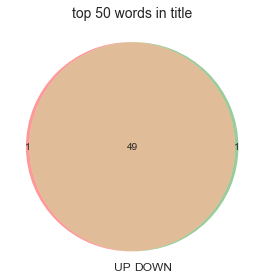

In [312]:
venn2([set(before_uni_upz_title_50.index), set(before_uni_downz_title_50.index)], set_labels = ('UP','DOWN'))
plt.title('top 50 words in title', fontsize=14)
plt.tight_layout()

#### Uni-gram Similarity in Up & Down Trend After Cleaning

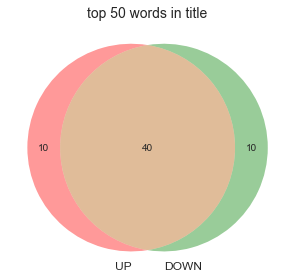

In [313]:
venn2([set(after_uni_upz_title_50.index), set(after_uni_downz_title_50.index)], set_labels = ('UP','DOWN'))
plt.title('top 50 words in title', fontsize=14)
plt.tight_layout()

#### Bi-gram Similarity in Up & Down Trend Before Cleaning

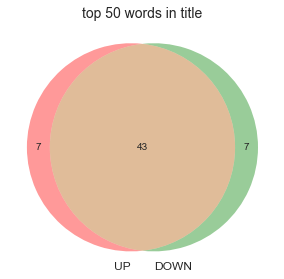

In [314]:
venn2([set(before_bi_upz_title_50.index), set(before_bi_downz_title_50.index)], set_labels = ('UP','DOWN'))
plt.title('top 50 words in title', fontsize=14)
plt.tight_layout()

#### Bi-gram Similarity in Up & Down Trend After Cleaning

In [315]:
venn2([set(after_bi_upz_title_50.index), set(after_bi_downz_title_50.index)], set_labels = ('UP','DOWN'))
plt.title('top 50 words in title', fontsize=14)
plt.tight_layout()

#### Tri-gram Similarity in Up & Down Trend Before Cleaning

In [316]:
venn2([set(before_tri_upz_title_50.index), set(before_tri_downz_title_50.index)], set_labels = ('UP','DOWN'))
plt.title('top 50 words in title', fontsize=14)
plt.tight_layout()

#### Tri-gram Similarity in Up & Down Trend After Cleaning

In [317]:
venn2([set(after_tri_upz_title_50.index), set(after_tri_downz_title_50.index)], set_labels = ('UP','DOWN'))
plt.title('top 50 words in title', fontsize=14)
plt.tight_layout()

## EDA Based on Daily Title Combined for 2019 & 2020
---

### Top 50 Title Content for Ups/Downs

In [204]:
dailytitle_df.shape

(502, 9)

In [205]:
dailytitle_df.head()

Date                                     combined_title  \
0  2019-01-03  Backtesting moving average crossover Can someo...   
1  2019-01-04  What’s your best performing stock today? How t...   
2  2019-01-07  Come Join Quantum Stock Trading! Help reach fi...   
3  2019-01-08  Greenspan says stock market "is still a bit to...   
4  2019-01-09  ONC, ONCY &amp; ONC.WT What is everyone's opin...   

  percent_change_class  title_len  \
0                   up        108   
1                   up        503   
2                   up        209   
3                   up        541   
4                   up        472   

                                       title_cleaned  sentiment_pos  \
0  backtesting moving average crossover someone e...          0.087   
1  best performing stock today explain option new...          0.130   
2  come join quantum stock trading help reach fin...          0.179   
3  greenspan say stock market still bit high appl...          0.219   
4  onc oncy amp onc wt everyone opinion company d...          0.126   

   sentiment_neu  sentiment_neg  sentiment_compound  
0          0.752          0.161             -0.6908  
1          0.771          0.099              0.8470  
2          0.709          0.112              0.8481  
3          0.737          0.044              0.9947  
4          0.761          0.113              0.5423

In [206]:
dailytitle_df.isnull().sum().sum()

0

In [207]:
ups = dailytitle_df[(dailytitle_df['percent_change_class'] == 'up')]
downs = dailytitle_df[(dailytitle_df['percent_change_class'] == 'down')]

In [208]:
print(ups['percent_change_class'].unique())
print(ups['percent_change_class'].shape)
print(downs['percent_change_class'].unique())
print(downs['percent_change_class'].shape)

['up']
(293,)
['down']
(209,)


#### Top 50 Word

In [209]:
# instantiate a basic vectoriser with only settings for extracting bi- and tri-grams
cvec = CountVectorizer(stop_words = 'english', ngram_range = (1,1), max_features=1000)

# upz - fit/transform count vectoriser to title and get the 50 phrases with the highest count
uni_upz = cvec.fit_transform(ups['title_cleaned'])
uni_upz = pd.DataFrame(uni_upz.toarray(), columns = cvec.get_feature_names())
uni_upz_title_50 = uni_upz.sum().sort_values(ascending=False).head(50)

# downz - fit/transform count vectoriser to title and get the 50 phrases with the highest count
uni_downz = cvec.fit_transform(downs['title_cleaned'])
uni_downz = pd.DataFrame(uni_downz.toarray(), columns = cvec.get_feature_names())
uni_downz_title_50 = uni_downz.sum().sort_values(ascending=False).head(50)

# plot results
fit, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(15,10), sharex = True)

sns.barplot(y=uni_upz_title_50.index.values, x = uni_upz_title_50,color='skyblue',ax=ax[0])
ax[0].set_title('top 50 words in UPs',fontsize=16)
ax[0].set_xlabel('count of words/phrases', fontsize=13)
plt.setp(ax[0].get_yticklabels(), fontsize=14)

sns.barplot(y=uni_downz_title_50.index.values, x = uni_downz_title_50,color='skyblue',ax=ax[1])
ax[1].set_title('top 50 words in DOWN',fontsize=16)
ax[1].set_xlabel('count of words/phrases', fontsize=13)
plt.setp(ax[1].get_yticklabels(), fontsize=14)

plt.tight_layout()

#### Top 50 Bigrams

In [210]:
# instantiate a basic vectoriser with only settings for extracting bi- and tri-grams
cvec = CountVectorizer(stop_words = 'english', ngram_range = (2,2), max_features=1000)

# upz - fit/transform count vectoriser to title and get the 50 phrases with the highest count
bi_upz = cvec.fit_transform(ups['title_cleaned'])
bi_upz = pd.DataFrame(bi_upz.toarray(), columns = cvec.get_feature_names())
bi_upz_title_50 = bi_upz.sum().sort_values(ascending=False).head(50)

# downz - fit/transform count vectoriser to title and get the 50 phrases with the highest count
bi_downz = cvec.fit_transform(downs['title_cleaned'])
bi_downz = pd.DataFrame(bi_downz.toarray(), columns = cvec.get_feature_names())
bi_downz_title_50 = bi_downz.sum().sort_values(ascending=False).head(50)

# plot results
fit, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(15,10), sharex = True)

sns.barplot(y=bi_upz_title_50.index.values, x = bi_upz_title_50,color='skyblue',ax=ax[0])
ax[0].set_title('top 50 words in UPs',fontsize=16)
ax[0].set_xlabel('count of words/phrases', fontsize=13)
plt.setp(ax[0].get_yticklabels(), fontsize=14)

sns.barplot(y=bi_downz_title_50.index.values, x = bi_downz_title_50,color='skyblue',ax=ax[1])
ax[1].set_title('top 50 words in DOWN',fontsize=16)
ax[1].set_xlabel('count of words/phrases', fontsize=13)
plt.setp(ax[1].get_yticklabels(), fontsize=14)

plt.tight_layout()

#### Top 50 Trigrams

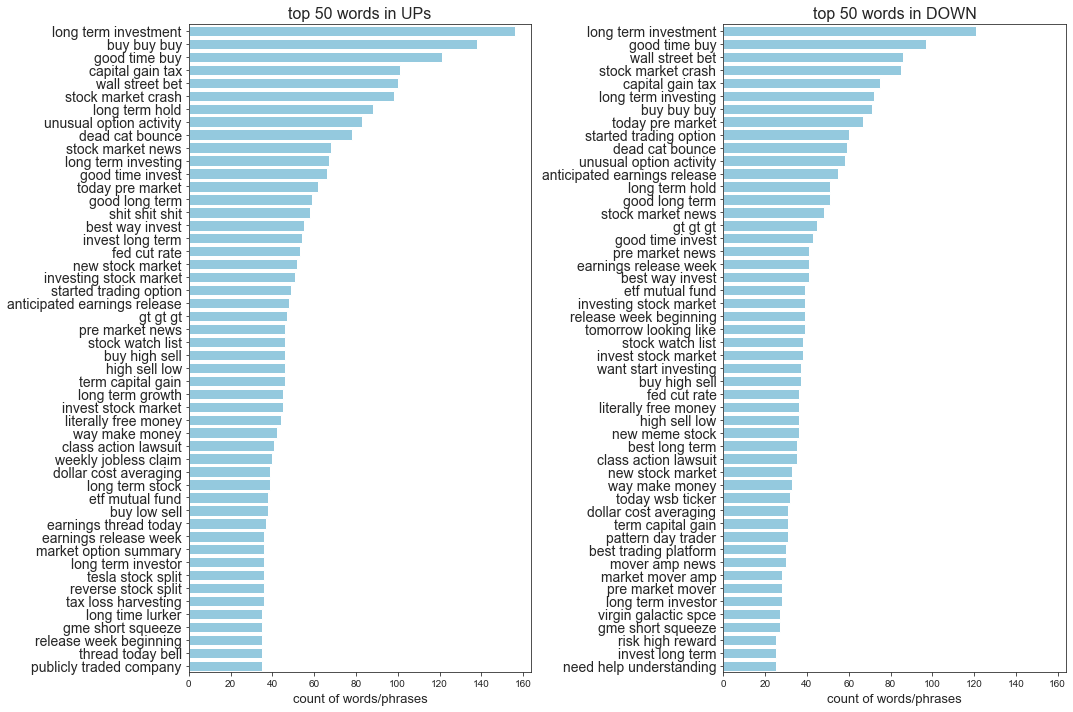

In [211]:
# instantiate a basic vectoriser with only settings for extracting bi- and tri-grams
cvec = CountVectorizer(stop_words = 'english', ngram_range = (3,3), max_features=1000)

# upz - fit/transform count vectoriser to title and get the 50 phrases with the highest count
tri_upz = cvec.fit_transform(ups['title_cleaned'])
tri_upz = pd.DataFrame(tri_upz.toarray(), columns = cvec.get_feature_names())
tri_upz_title_50 = tri_upz.sum().sort_values(ascending=False).head(50)

# downz - fit/transform count vectoriser to title and get the 50 phrases with the highest count
tri_downz = cvec.fit_transform(downs['title_cleaned'])
tri_downz = pd.DataFrame(tri_downz.toarray(), columns = cvec.get_feature_names())
tri_downz_title_50 = tri_downz.sum().sort_values(ascending=False).head(50)

# plot results
fit, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(15,10), sharex = True)

sns.barplot(y=tri_upz_title_50.index.values, x = tri_upz_title_50,color='skyblue',ax=ax[0])
ax[0].set_title('top 50 words in UPs',fontsize=16)
ax[0].set_xlabel('count of words/phrases', fontsize=13)
plt.setp(ax[0].get_yticklabels(), fontsize=14)

sns.barplot(y=tri_downz_title_50.index.values, x = tri_downz_title_50,color='skyblue',ax=ax[1])
ax[1].set_title('top 50 words in DOWN',fontsize=16)
ax[1].set_xlabel('count of words/phrases', fontsize=13)
plt.setp(ax[1].get_yticklabels(), fontsize=14)

plt.tight_layout()

### Boxplot of Title and Post For Up and Down Trend

In [212]:
# plot distributions with same x axis range for each category
fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize = (16, 8))

sns.boxplot(ups['title_len'], ax = ax[0], width = 0.2)
ax[0].set_xlabel('')
ax[0].set_title('UP Title Length', fontsize=14)

sns.boxplot(downs['title_len'], ax = ax[1], width = 0.2)
ax[1].set_xlabel('')
ax[1].set_title('DOWN title lengths', fontsize=14)

plt.tight_layout();

### Histogram of Title and Post for Up and Down Trend

In [213]:
# plot distributions with same x axis range for each category
fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize = (16, 8))

sns.distplot(ups['title_len'], ax = ax[0])
ax[0].set_xlabel('')
ax[0].set_title('UP Title Lengths', fontsize=14)

sns.distplot(downs['title_len'], ax = ax[1])
ax[1].set_xlabel('')
ax[1].set_title('DOWN Title Lengths', fontsize=14)

plt.tight_layout()

### WordCloud for UP and Down Trend

#### Top 50 Words in Up and Down Trend

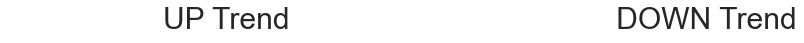

In [214]:
# set up WordCloud
wc_up = WordCloud(max_words= 50, width = 1000, height = 800, background_color ='black',
                  colormap='ocean').generate_from_frequencies(uni_upz_title_50) 

wc_down = WordCloud(max_words= 50, width = 1000, height = 800, background_color ='black',
                  colormap='ocean').generate_from_frequencies(uni_downz_title_50) 

plt.figure(figsize=(8, 0.3))
plt.text(x = 0.35,                              
         y = 0.9,                             
         s = 'UP Trend                                       DOWN Trend', 
         ha = 'left',                        
         va = 'center',                       
         size = 30)                         
plt.axis('off')

# plot the WordCloud image 
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (14, 6))
ax[0].imshow(wc_up)
ax[0].axis('off')
ax[1].imshow(wc_down)
ax[1].axis('off')
plt.tight_layout()

#### Top 50 Bi-gram in Up and Down Trend

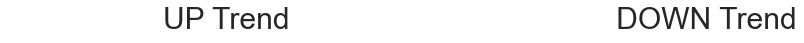

In [215]:
# set up WordCloud
bi_wc_up = WordCloud(max_words= 50, width = 1000, height = 800, background_color ='black',
                  colormap='ocean').generate_from_frequencies(bi_upz_title_50) 

bi_wc_down = WordCloud(max_words= 50, width = 1000, height = 800, background_color ='black',
                  colormap='ocean').generate_from_frequencies(bi_downz_title_50) 

plt.figure(figsize=(8, 0.3))
plt.text(x = 0.35,                              
         y = 0.9,                             
         s = 'UP Trend                                       DOWN Trend', 
         ha = 'left',                        
         va = 'center',                       
         size = 30)                         
plt.axis('off')

# plot the WordCloud image 
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (14, 6))
ax[0].imshow(bi_wc_up)
ax[0].axis('off')
ax[1].imshow(bi_wc_down)
ax[1].axis('off')
plt.tight_layout()

#### Top 50 Tri-grams in Up and Down Trend

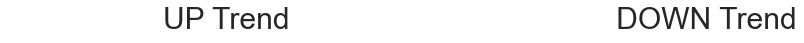

In [216]:
# set up WordCloud
tri_wc_up = WordCloud(max_words= 50, width = 1000, height = 800, background_color ='black',
                  colormap='ocean').generate_from_frequencies(tri_upz_title_50) 

tri_wc_down = WordCloud(max_words= 50, width = 1000, height = 800, background_color ='black',
                  colormap='ocean').generate_from_frequencies(tri_downz_title_50) 

plt.figure(figsize=(8, 0.3))
plt.text(x = 0.35,                              
         y = 0.9,                             
         s = 'UP Trend                                       DOWN Trend', 
         ha = 'left',                        
         va = 'center',                       
         size = 30)                         
plt.axis('off')

# plot the WordCloud image 
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (14, 6))
ax[0].imshow(tri_wc_up)
ax[0].axis('off')
ax[1].imshow(tri_wc_down)
ax[1].axis('off')
plt.tight_layout()

### Venn Diagram for top 50

#### Uni-gram Similarity in Up & Down Trend

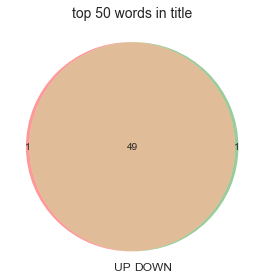

In [217]:
venn2([set(uni_upz_title_50.index), set(uni_downz_title_50.index)], set_labels = ('UP','DOWN'))
plt.title('top 50 words in title', fontsize=14)
plt.tight_layout()

#### Bi-gram Similarity in Up & Down Trend

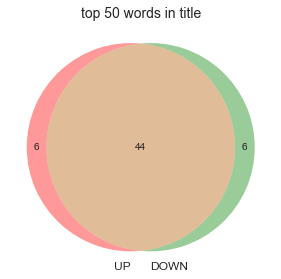

In [218]:
venn2([set(bi_upz_title_50.index), set(bi_downz_title_50.index)], set_labels = ('UP','DOWN'))
plt.title('top 50 words in title', fontsize=14)
plt.tight_layout()

#### Tri-gram Similarity in Up & Down Trend

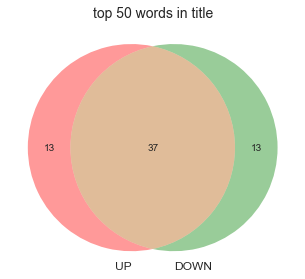

In [219]:
venn2([set(tri_upz_title_50.index), set(tri_downz_title_50.index)], set_labels = ('UP','DOWN'))
plt.title('top 50 words in title', fontsize=14)
plt.tight_layout()

## Conclusion

Overall, the EDA process is a very good indicator that there will be a huge challenge in producing a good model due to the huge similarity in the features against two different classifiers. There are also additional insights to consider to be part of the feature like comparing the number of posts during a certain period of time to better classify between up and down trends.

In Sentiment Analysis, both dailytitle and titlepost dataset shows that even the most positive or negative sentiment, contains posts that were either in the up or down trend in either sentiments. This is also possibily due to having neutrality within some of the posts. 

Number of posts by year shows a high surge from one year to another. This was due to the pandemic(corona/Covid-19) faced in 2020 which caused a lot of uncertainty within the stock market and worries among the investors. Comparing year-on-year, keywords like Covid, Corona, Correction, Market Crash, appeared more in 2020 as compared with 2019. Generally, in 2019, the number of posts was less than 10,000 per month as there was nothing significant occuring during that year. However, in 2020, the number of posts surged throughout the months. Especially in Mar 2020, where there was a huge market correction which got many investors concerned. Hence, the huge spike in the number of posts.

Comparing the number of posts, it seems to indicate that in an event of a significant change in the market, the number of posts for that month will significantly increase also. Most dates shows that there was a huge change in the period of Mar 2020. Hence, top 30 changes during the period of 2019 and 2020 are mainly due to performance of the stock market in Mar 2020.

In the following EDA, the top 50 uni-gram/bi-gram/trigram were reflected with emphasis to two stages; (1) Before increasing the stopwords and (2) After increasing the stopwords.Before cleaning, there are a huge amount of similar words between the Up and down trends. Despite cleaning, there still remains a huge amount of similar words between the Up and down trends. 